In [1]:
# type: ignore
import numpy as np

from nanopyx.core.transform.binning import rebin_2d
from nanopyx.core.transform.image_magnify import *
from nanopyx.data.download import ExampleDataManager
from nanopyx.core.generate.noise_add_random_noise import get_perlin_noise

M = 4
# downloader = ExampleDataManager()
# z = downloader.get_ZipTiffIterator('LongContinuous_UtrGFP')
# z = downloader.get_ZipTiffIterator('SMLMS2013_HDTubulinAlexa647')
#image = z[0]

image = get_perlin_noise(32*M, 64*M, amp=1000, f=10, octaves=3)

imageDownsampled = rebin_2d(image, M, mode="mean")

In [2]:
%%prun -s cumulative -q -l 100 -T prun_magnify.profile
# Profile the run

imageFFTZoom = fourier_zoom(imageDownsampled.astype(np.float32), M)
imageNNZoom = nearest_neighbor_zoom(imageDownsampled, M)
imageBLZoom = bilinear_zoom(imageDownsampled, M)
imageBCZoom = bicubic_zoom(imageDownsampled, M)
imageCRZoom = catmull_rom_zoom(imageDownsampled, M)
imageLZoom = lanczos_zoom(imageDownsampled, M, taps = 4)
imageScipyZoom = scipy_zoom(imageDownsampled, M)
imageSkiZoom = skimage_zoom(imageDownsampled, M)
imageCVZoom = cv2_zoom(imageDownsampled, M)


interpolated_images = {
    "fft-zoom": imageFFTZoom,
    "nearest-neighbor-zoom": imageNNZoom,
    "bilinear-zoom": imageBLZoom,
    "bicubic-zoom": imageBCZoom,    
    "catmull-rom-zoom": imageCRZoom,
    "lanczos-zoom": imageLZoom,
    "scipy-zoom": imageScipyZoom,
    "skimage-rescale": imageSkiZoom,
    "cv2-resize": imageCVZoom
}

fourier_zoom took 2.940893 mseconds
nearest_neighbor_zoom took 1.302958 mseconds
bilinear_zoom took 0.698805 mseconds
bicubic_zoom took 0.769138 mseconds
catmull_rom_zoom took 0.862122 mseconds
lanczos_zoom took 19.118309 mseconds
scipy_zoom took 5.406857 mseconds
skimage_zoom took 2.698898 mseconds
cv2_zoom took 16.131878 mseconds
 
*** Profile printout saved to text file 'prun_magnify.profile'.


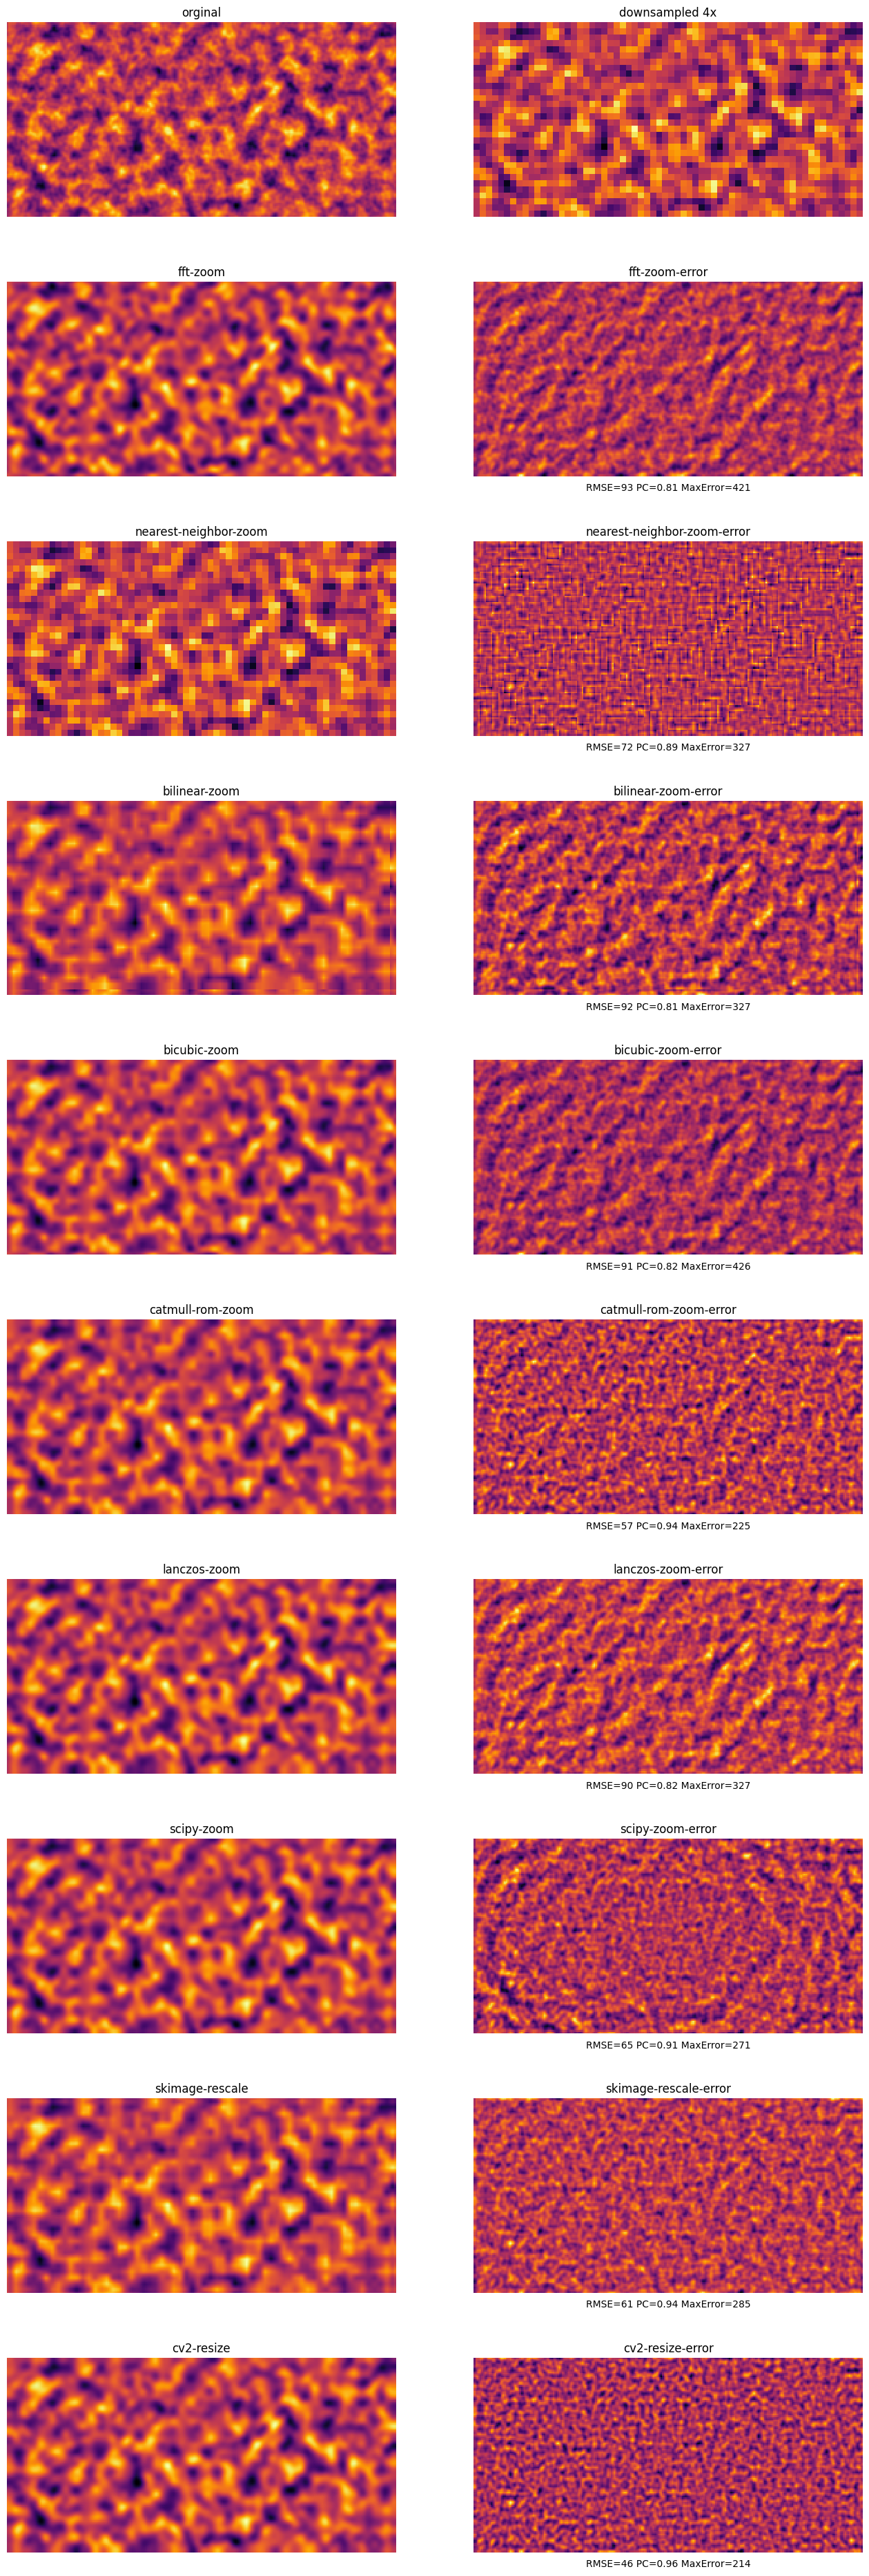

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
from nanopyx.core.analysis.pearson_correlation import pearson_correlation
import numpy as np

# Create a figure with 3 subplots arranged in a row
fig, axs = plt.subplots(len(interpolated_images)+1, 2, figsize=(16, 3*16))
sns.heatmap(image, ax=axs[0,0], cmap='inferno', cbar=False, square=True, xticklabels=False, yticklabels=False)
sns.heatmap(imageDownsampled, ax=axs[0,1], cmap='inferno', cbar=False, square=True, xticklabels=False, yticklabels=False)
axs[0,0].set_title("orginal")
axs[0,1].set_title(f"downsampled {M}x")

for i, id in enumerate(interpolated_images):
    interpolated_image = interpolated_images[id]
    error = image-interpolated_image
    rmse = round((error**2).mean()**0.5)
    pc = pearson_correlation(image, interpolated_image)
    sns.heatmap(interpolated_image, ax=axs[i+1,0], cmap='inferno', cbar=False, square=True, xticklabels=False, yticklabels=False)
    sns.heatmap(error, ax=axs[i+1,1], cmap='inferno', cbar=False, square=True, xticklabels=False, yticklabels=False)
    axs[i+1,0].set_title(f"{id}")
    axs[i+1,1].set_title(f"{id}-error")
    axs[i+1,1].set_xlabel(f"RMSE={rmse} PC={round(pc, 2)} MaxError={round(np.max(error))}")

# Show the figure
plt.show()
